# Problem Description

Companies like Netflix, Youtube, Amazon etc., leverage reccomedation systems to help users discover new and relevant items (movies, videos, music, products), creating a delightful user experience while driving incremental revenue.

Most recommender systems are typically classified into two broad categories- 
1. Contend Based
2. Collaborative filtering

However, complex algorithms can implement both approaches. Content-based methods leverge similarity of item attributes while collaborative based approach make used of similarity among users/interactions.

Here we implement a recommender system for restaurants using user-based collaborative filtering approach. Food application companies such as Hungrygowhere, Zomato, Grab can leverage such system to provide explicit range of restaurants based on customer's previous choices and interests.

# Data Description

Here I have use Toronto neighborhood data with geolocation information, which I scraped from wikipedia in the last week's assignment. I am using only those neighborhood areas which are inside Boroughs containing 'Toronto' in it. 

For all these neighborhoods, I extracted nearby Restaurants within the radius of 5kms using Foursquare api. So, we hve in total 20 restaurants. I also created unique ids for each restaurant for later reference using uuid.
Restaurant data comprise of : Restaurant id, Category, Geolocation, Neighborhood information.

For rating data, I used a random dataset of 1000 users who provided 5- star ratings to these restaurants.

Rating data comprise of User Id, Restarant id, rating and timestamp information.

# Implementation

## Import libraries

In [155]:
import numpy as np 
import pandas as pd 
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load dataset

In [156]:
users = pd.read_csv(r'data\rating.csv')
restaurants = pd.read_csv(r'data\restaurants.csv')

In [157]:
restaurants.loc[12,:]

Unnamed: 0                                                         433
Neighborhood              Brockton, Parkdale Village, Exhibition Place
Neighborhood Latitude                                          43.6368
Neighborhood Longitude                                        -79.4282
Venue                                      INJapan Japanese Restaurant
Venue Latitude                                                 43.6395
Venue Longitude                                               -79.4212
categories                                         Japanese Restaurant
Id                                9ff29572-1b74-4d4d-aef4-8aa4f0b696c2
Name: 12, dtype: object

In [158]:
#Clean Venue column and remove unwanted characters
restaurants['Venue'] = restaurants['Venue'].str.replace('[^a-zA-Z.*\s]', '')

## Exploratory analysis

In [159]:
#Join restaurant id with user table

df_rest = restaurants[['Id', 'Venue', 'categories', 'Neighborhood']].set_index('Id')

df = users.join(df_rest, how = 'left', on = 'restaurant_id')

In [160]:
df.head()

,userId,rating,timestamp,restaurant_id,Venue,categories,Neighborhood
0,64,3.5,1434644734,46cc8bbc-1bfa-4364-bc40-aba5ade3ab4c,T.C.J. Restaurant,Asian Restaurant,St. James Town
1,471,5.0,1500417760,0c13a72c-9ada-4ee2-b986-2b31f9fd69a6,Florentinas Italian Restaurant,Italian Restaurant,"The Danforth West, Riverdale"
2,301,1.5,1484675858,9ff29572-1b74-4d4d-aef4-8aa4f0b696c2,INJapan Japanese Restaurant,Japanese Restaurant,"Brockton, Parkdale Village, Exhibition Place"
3,125,4.0,1023423520,de28d0e2-d21b-4caa-9c20-463391c555b4,EdoKo Japanese Restaurant,Japanese Restaurant,"Forest Hill North & West, Forest Hill Road Park"
4,230,3.0,864120692,d4e313a8-ff3f-4d1b-840b-5de94929f4a1,Whitehorse Restaurant,Italian Restaurant,"India Bazaar, The Beaches West"


[Text(0, 0, 'Asian Restaurant'),
 Text(0, 0, 'Italian Restaurant'),
 Text(0, 0, 'Japanese Restaurant'),
 Text(0, 0, 'Middle Eastern Restaurant'),
 Text(0, 0, 'Spanish Restaurant')]

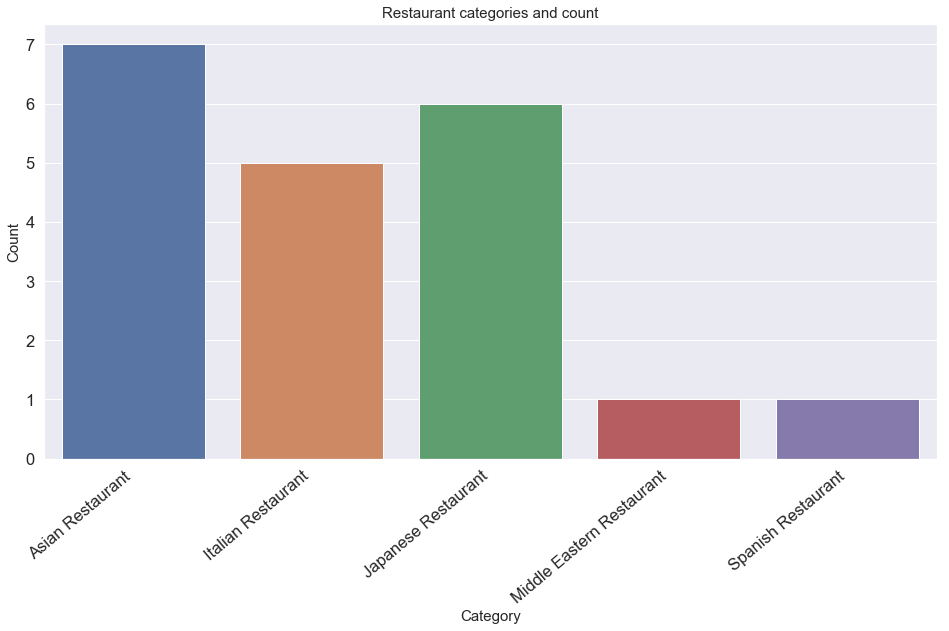

In [182]:
plt.figure(figsize=(16,8))

sns.set(style="darkgrid", font_scale= 1.5)
b = sns.countplot(x="categories", data=df_rest)
b.axes.set_title("Restaurant categories and count",fontsize=15)
b.set_xlabel("Category",fontsize=15)
b.set_ylabel("Count",fontsize=15)
b.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


[Text(0, 0, 'T.C.J. Restaurant'),
 Text(1, 0, 'Florentinas Italian Restaurant'),
 Text(2, 0, 'INJapan Japanese Restaurant'),
 Text(3, 0, 'EdoKo Japanese Restaurant'),
 Text(4, 0, 'Whitehorse Restaurant'),
 Text(0, 0, 'Lucky Star Restaurant'),
 Text(0, 0, 'Yulla Asian Fusion Restaurant'),
 Text(0, 0, 'Copetin Restaurant And Bar'),
 Text(0, 0, 'LOLO restaurant'),
 Text(0, 0, 'TCJ Restaurant'),
 Text(0, 0, 'Isabellas Boutique Restaurant'),
 Text(0, 0, 'Rossini Restaurant'),
 Text(0, 0, 'Divino Restaurant'),
 Text(0, 0, 'Bikkuri Japanese Restaurant'),
 Text(0, 0, 'Al Sherooq Restaurant'),
 Text(0, 0, 'Ho Su Korean  Japanese Restaurant')]

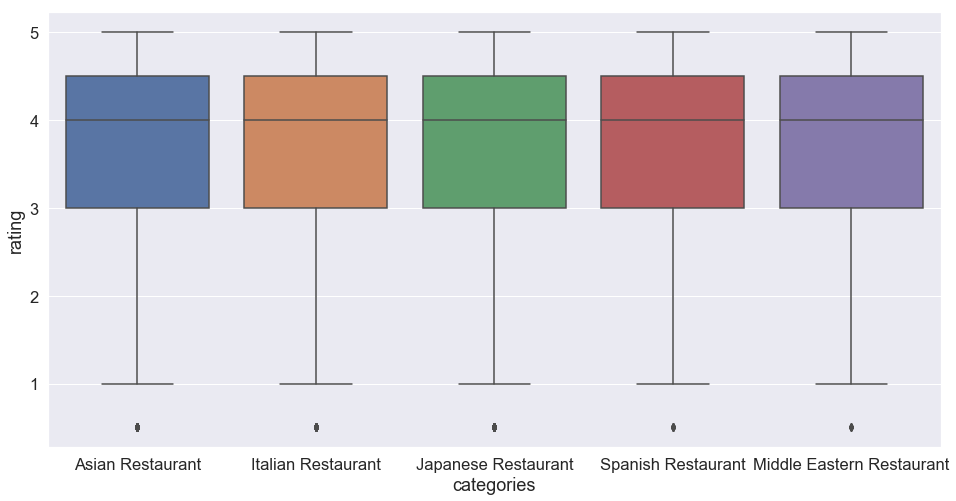

In [192]:
# Average rating of the restaurants
plt.figure(figsize=(16,8))

sns.set(style="darkgrid", font_scale= 1.5)
sns.boxplot(data=df, x='categories', y='rating')
b.axes.set_title("Average rating of the restaurants",fontsize=15)
b.set_xlabel("Restaurant",fontsize=15)
b.set_ylabel("Average rating",fontsize=15)
b.set_xticklabels(b.get_xticklabels(), rotation=90, ha="right")


Text(0, 0.5, 'Average rating')

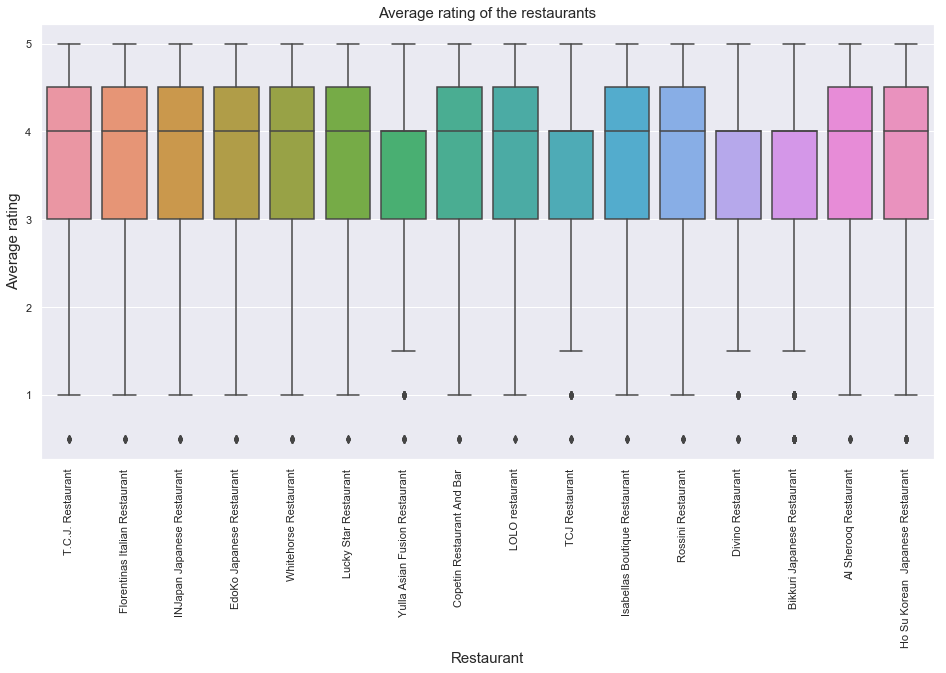

In [204]:
# Average rating of the restaurants
plt.figure(figsize=(16,8))

sns.set(style="darkgrid", font_scale= 1)
b = sns.boxplot(data=df, x='Venue', y='rating')
b.set_xticklabels(b.get_xticklabels(), rotation=90)
b.axes.set_title("Average rating of the restaurants",fontsize=15)
b.set_xlabel("Restaurant",fontsize=15)
b.set_ylabel("Average rating",fontsize=15)


Text(0, 0.5, 'Count')

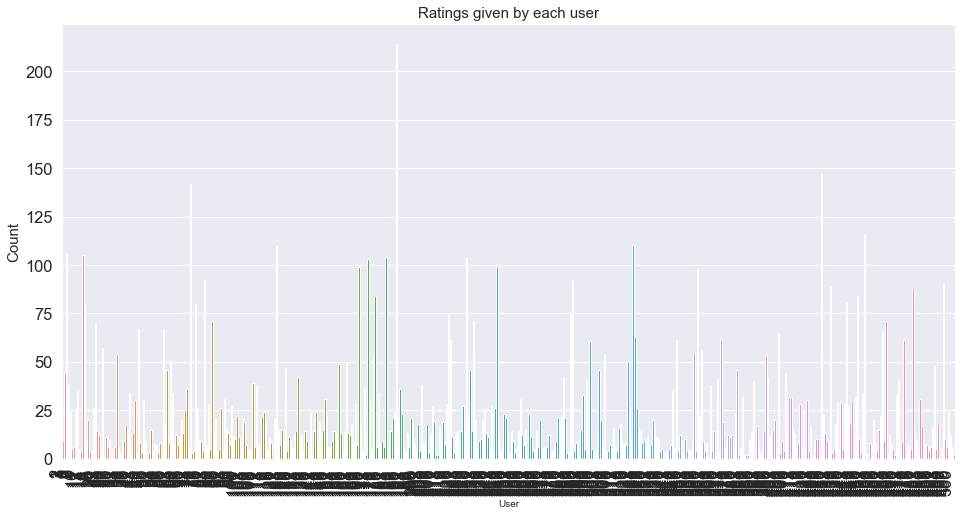

In [212]:
plt.figure(figsize=(16,8))

sns.set(style="darkgrid", font_scale= 1.5)
b = sns.countplot(x="userId", data=df)
b.set_xticklabels(b.get_xticklabels(), rotation=90, ha="right")
b.axes.set_title("Ratings given by each user",fontsize=15)
b.set_xlabel("User",fontsize=10)
b.set_ylabel("Count",fontsize=15)


In [231]:
df_rest['categories'].describe()

count                   20
unique                   5
top       Asian Restaurant
freq                     7
Name: categories, dtype: object

In [232]:
df_users = users[['userId','restaurant_id', 'rating', 'timestamp']]

In [233]:
train_data, test_data = train_test_split(df_users, test_size = 0.2)

In [234]:
n_users = train_data.userId.unique().shape[0]
n_items = train_data.restaurant_id.unique().shape[0]

print('Number of unique users: {}'.format(n_users))
print('Number of unique venues: {}'.format(n_items))

Number of unique users: 497
Number of unique venues: 20


In [230]:
avg_num_reviews = train_data.groupby('userId')['rating'].count()
print("Avg Number of ratings per reviewer {}".format(avg_num_reviews.mean()))

Avg Number of ratings per reviewer 16.129032258064516


Text(0, 0.5, 'number of reviewers')

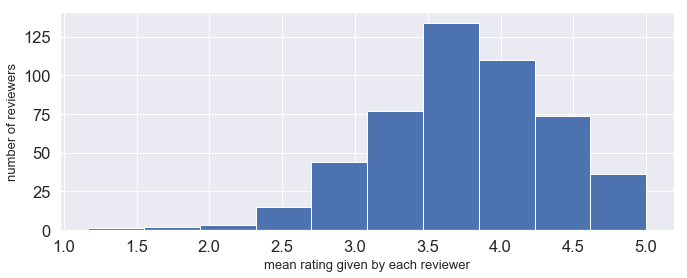

In [229]:
mean_rating_of_user = train_data.groupby('userId').apply(lambda x: x['rating'].mean())

fig = plt.figure(figsize=(11,4))
ax  = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

## Create user-item matrix

In [260]:
#create a user-item matrix which can be used to calculate the similarity between users and items.
train_rating_matrix = train_data.pivot_table(index='userId', columns='restaurant_id', values='rating').fillna(0)
test_rating_matrix = test_data.pivot_table(index='userId', columns='restaurant_id', values='rating').fillna(0)

train_rating_matrix.head()



restaurant_id,043732fc-5008-4fcd-b09f-eac38498a14a,0c13a72c-9ada-4ee2-b986-2b31f9fd69a6,3053ee1e-57e2-4e95-b36e-1c1ab9e11f1d,3d3e0276-649f-4fea-b009-ade74e77668c,46cc8bbc-1bfa-4364-bc40-aba5ade3ab4c,49ee063c-f363-4971-b149-5985e4c63e67,4c72ec73-84aa-40c7-81ba-76581fd0a96d,67bb994f-7c15-43ea-bb0d-677c747cfa4b,89e31c94-1f8d-49df-8fd7-295c0a993bdd,9ff29572-1b74-4d4d-aef4-8aa4f0b696c2,a261073f-b584-4815-bcdf-70eabc64f1b4,a6c8414b-a34a-4ddf-914d-a6a3e78394df,ba15707f-12fe-4416-910c-5e5a8c722e9d,d2ff6ad7-4d52-466c-b43f-5dee1e18c797,d4e313a8-ff3f-4d1b-840b-5de94929f4a1,de1e4686-f9c9-416b-94a3-2122c5b63d54,de28d0e2-d21b-4caa-9c20-463391c555b4,df716507-0127-4805-95ca-4cfbb53fc3bc,ef279b96-4654-4c12-a82f-6ac70e567d2a,f59844f6-58d8-445e-b3e2-c9a229b9699e
userId,,,,,,,,,,,,,,,,,,,,
1,0.000000,3.0,0.0,0.0,0.000000,2.25,0.0,0.000000,0.000000,0.00,0.000000,4.000000,0.000000,0.000,0.00,3.250000,0.0,0.00,0.0,4.500000
2,0.000000,4.6,3.2,4.0,5.000000,3.25,0.0,2.500000,2.166667,3.25,3.833333,3.000000,4.500000,4.000,4.75,4.500000,5.0,4.75,3.5,2.250000
3,3.785714,3.5,3.6,4.0,3.600000,3.50,3.0,3.700000,3.666667,3.75,3.500000,3.166667,3.500000,3.625,4.00,3.833333,3.5,4.00,3.9,3.714286
4,1.500000,3.0,3.5,3.5,0.000000,3.50,1.5,2.833333,4.250000,4.50,3.333333,2.500000,0.000000,4.000,2.75,4.000000,0.0,3.50,3.0,0.000000
5,5.000000,3.0,0.0,5.0,3.666667,3.00,5.0,4.000000,2.000000,2.00,0.000000,5.000000,3.666667,0.000,5.00,4.000000,0.0,0.00,4.5,3.000000


## Calculate user-user and item-item similarity

A distance metric commonly used in recommender systems is cosine similarity, where the ratings are seen as vectors in n-dimensional space and the similarity is calculated based on the angle between these vectors. Cosine similarity for users a and m can be calculated using the formula below, where you take dot product of the user vector uk“>𝑢𝑘uk and the user vector ua“>𝑢𝑎ua and divide it by multiplication of the Euclidean lengths of the vectors.

In [236]:
#Calculate cosine similarity 

from sklearn.metrics import pairwise_distances

user_similarity = pairwise_distances(train_rating_matrix.fillna(0), metric = 'cosine')
item_similarity = pairwise_distances(train_rating_matrix.fillna(0).T, metric = 'cosine')

In [238]:
#get cosine similarities for ratings matrix ; pairwise_distances returns the distances between ratings and hence
#similarities are obtained by subtracting distances from 1
cosine_sim = 1 - user_similarity

In [239]:
#Cosine similarity matrix
pd.DataFrame(cosine_sim)

,0,1,2,3,4,5,6,7,8,9,...,487,488,489,490,491,492,493,494,495,496
0,1.000000,0.449586,0.472690,0.386594,0.515935,0.615309,0.000000,0.317735,0.410846,0.000000,...,0.231448,0.000000,0.000000,0.498375,0.000000,0.000000,0.315417,0.422196,0.183751,0.294543
1,0.449586,1.000000,0.929380,0.805974,0.699627,0.379230,0.473845,0.642140,0.862446,0.351543,...,0.763707,0.131349,0.250837,0.904868,0.399298,0.313527,0.861686,0.501982,0.385536,0.396517
2,0.472690,0.929380,1.000000,0.873740,0.833547,0.366810,0.436519,0.736922,0.900180,0.393303,...,0.774558,0.224578,0.359513,0.992467,0.489090,0.455306,0.876300,0.628343,0.425542,0.339256
3,0.386594,0.805974,0.873740,1.000000,0.668108,0.409920,0.280886,0.470896,0.811741,0.481381,...,0.734704,0.321487,0.251120,0.855895,0.473984,0.468598,0.798392,0.523649,0.342029,0.361046
4,0.515935,0.699627,0.833547,0.668108,1.000000,0.503301,0.275940,0.616302,0.743591,0.250490,...,0.630620,0.129332,0.261344,0.845418,0.261548,0.405736,0.664895,0.534042,0.337557,0.411531
5,0.615309,0.379230,0.366810,0.409920,0.503301,1.000000,0.000000,0.180324,0.330227,0.201259,...,0.266667,0.000000,0.000000,0.391766,0.000000,0.223235,0.182344,0.000000,0.256699,0.411476
6,0.000000,0.473845,0.436519,0.280886,0.275940,0.000000,1.000000,0.244120,0.416850,0.000000,...,0.406582,0.000000,0.213201,0.439962,0.000000,0.000000,0.523059,0.000000,0.217197,0.000000
7,0.317735,0.642140,0.736922,0.470896,0.616302,0.180324,0.244120,1.000000,0.710086,0.205775,...,0.473914,0.000000,0.365771,0.754698,0.659792,0.315597,0.602925,0.389337,0.496161,0.233727
8,0.410846,0.862446,0.900180,0.811741,0.743591,0.330227,0.416850,0.710086,1.000000,0.133675,...,0.658035,0.000000,0.247942,0.889161,0.509127,0.205017,0.735202,0.534009,0.423989,0.303665
9,0.000000,0.351543,0.393303,0.481381,0.250490,0.201259,0.000000,0.205775,0.133675,1.000000,...,0.321378,0.553372,0.319489,0.395128,0.313112,0.863294,0.456761,0.209904,0.000000,0.000000


## Make Predictions

In [249]:
#This function finds k similar users given the user_id and ratings matrix M
#Note that the similarities are same as obtained via using pairwise_distances
from sklearn.neighbors import NearestNeighbors
def findksimilarusers(user_id, ratings, metric, k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.iloc[user_id-1, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print('{0} most similar users for User {1}:\n'.format(k,user_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;

        else:
            print('{0}: User {1}, with similarity of {2}'.format(i, indices.flatten()[i]+1, similarities.flatten()[i]))
            
    return similarities,indices

In [250]:
similarities,indices = findksimilarusers(1,train_rating_matrix.fillna(0), k = 4, metric='cosine')

4 most similar users for User 1:

1: User 472, with similarity of 0.9476609356270141
2: User 162, with similarity of 0.7700769315417864
3: User 83, with similarity of 0.6798734977619258
4: User 135, with similarity of 0.6767587118081178


You can look at the similarity between users k and a as weights that are multiplied by the ratings of a similar user a (corrected for the average rating of that user). You will need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that you are trying to predict.
The idea here is that certain users may tend always to give high or low ratings to all restaurants. The relative difference in the ratings that these users give is more important than the absolute rating values. 

## Discussion

This method also called Memory-based algorithms are easy to implement and produce reasonable prediction quality. The drawback of memory-based CF is that it doesn’t scale to real-world scenarios and doesn’t address the well-known cold-start problem, that is when a new user or new item enters the system. Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don’t have any ratings enter the system.